INSTALL LIBRARIES:

In [40]:
!pip install sentence-transformers pdfplumber python-docx spacy fuzzywuzzy

# Download spaCy English model
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


UPLOAD FILES:

In [42]:
from google.colab import files

print("Upload your Job Description file (PDF or TXT), then your Resumes (PDF or DOCX):")
uploaded = files.upload()


Upload your Job Description file (PDF or TXT), then your Resumes (PDF or DOCX):


Saving Aiswarya.txt to Aiswarya (2).txt
Saving Ajmal_resume.pdf to Ajmal_resume (2).pdf
Saving job_description.pdf to job_description (2).pdf
Saving NAJIYA_resume.pdf to NAJIYA_resume (2).pdf
Saving richard_resume.pdf to richard_resume (2).pdf


TEXT EXTRACTION:

In [43]:
import pdfplumber
def extract_text_pdf(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
    return text

def extract_text_docx(docx_path):
    return docx2txt.process(docx_path)

def extract_text_txt(txt_path):
    with open(txt_path, 'r', encoding='utf-8') as f:
        return f.read()

def extract_text(filename):
    if filename.lower().endswith(".pdf"):
        return extract_text_pdf(filename)
    elif filename.lower().endswith(".docx"):
        return extract_text_docx(filename)
    elif filename.lower().endswith(".txt"):
        return extract_text_txt(filename)
    else:
        return ""

jd_text = ""
resumes_text = {}

for filename in uploaded.keys():
    with open(filename, "wb") as f:
        f.write(uploaded[filename])
    text = extract_text(filename)
    if "job_description" in filename.lower():
        jd_text = text
    else:
        resumes_text[filename] = text

if not jd_text.strip():
    print("⚠️ Warning: Job Description text is empty or missing!")
else:
    print("✅ Job Description loaded successfully.")


✅ Job Description loaded successfully.


BIAS REDUCTION:

In [44]:
import re

def anonymize_text(text):
    # Example: remove names (simple pattern for capitalized words) and emails
    text = re.sub(r"\b[A-Z][a-z]+ [A-Z][a-z]+\b", "[NAME]", text)
    text = re.sub(r"\S+@\S+", "[EMAIL]", text)
    return text

apply_bias_reduction = True

if apply_bias_reduction:
    jd_text = anonymize_text(jd_text)
    for k,v in resumes_text.items():
        resumes_text[k] = anonymize_text(v)
    print("✅ Bias reduction applied (anonymization)")
else:
    print("Bias reduction skipped.")


✅ Bias reduction applied (anonymization)


KEYWORD AND PHRASE EXTRACTION:

In [45]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_keywords_phrases(text, top_k=30):
    doc = nlp(text.lower())
    # Extract noun chunks as candidate keywords/phrases
    phrases = [chunk.text.strip() for chunk in doc.noun_chunks if len(chunk.text) > 1]

    # Simple frequency count
    freq = {}
    for phrase in phrases:
        freq[phrase] = freq.get(phrase, 0) + 1

    # Sort by frequency and pick top_k
    sorted_phrases = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    return set([p[0] for p in sorted_phrases[:top_k]])

jd_keywords = extract_keywords_phrases(jd_text)
print("Top Job Description Keywords/Phrases:")
print(jd_keywords)


Top Job Description Keywords/Phrases:
{'digital marketing\ncampaigns', 'state', 'website', '(cid:127) manage', 'a creative and data-driven [name] specialist', 'the ideal candidate', 'you', 'current marketing tools', 'concept', 'brand awareness', 'leads', 'execution', 'content', 'best practices', 'integrated digital marketing campaigns', 'digital platforms', 'blogs', 'planning', '[name]: [name] specialist\nlocation', 'all digital networks', 'head', '[city', '[name] manager', 'our marketing team', 'a strong grasp', 'marketing', 'digital marketing campaigns', 'traffic', 'we', 'strategies'}


SEMANTIC EMBEDDINGS:

In [46]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode JD once
jd_embedding = model.encode(jd_text, convert_to_tensor=True)

# Encode each resume
resumes_embeddings = {}
for name, text in resumes_text.items():
    resumes_embeddings[name] = model.encode(text, convert_to_tensor=True)

print("✅ Semantic embeddings generated for JD and resumes.")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.



✅ Semantic embeddings generated for JD and resumes.


SIMILARITY CALCULATION:

In [47]:
print("Similarity Scores and Missing Skills per Resume:\n")

for name, embedding in resumes_embeddings.items():
    # Semantic similarity score
    similarity = util.cos_sim(jd_embedding, embedding).item()

    # Extract keywords from resume for skill gap
    resume_keywords = extract_keywords_phrases(resumes_text[name])
    missing_skills = jd_keywords - resume_keywords

    print(f"Resume: {name}")
    print(f"Semantic Similarity Score: {similarity:.4f}")
    print(f"Missing Skills: {missing_skills}\n")


Similarity Scores and Missing Skills per Resume:

Resume: Aiswarya (2).txt
Semantic Similarity Score: 0.6144
Missing Skills: {'digital marketing\ncampaigns', 'website', '(cid:127) manage', 'we', 'a creative and data-driven [name] specialist', 'the ideal candidate', 'you', 'current marketing tools', 'concept', 'leads', 'execution', 'content', 'best practices', 'integrated digital marketing campaigns', 'digital platforms', 'blogs', 'planning', '[name]: [name] specialist\nlocation', 'all digital networks', 'head', '[city', '[name] manager', 'our marketing team', 'a strong grasp', 'marketing', 'digital marketing campaigns', 'traffic', 'state', 'strategies'}

Resume: Ajmal_resume (2).pdf
Semantic Similarity Score: 0.1757
Missing Skills: {'digital marketing\ncampaigns', 'digital platforms', 'website', '(cid:127) manage', 'we', 'a creative and data-driven [name] specialist', 'blogs', 'planning', '[name]: [name] specialist\nlocation', 'all digital networks', 'the ideal candidate', 'you', 'curr

SCORE AGGREGATION AND RANKING:

In [48]:
import pandas as pd

results = []

for name, embedding in resumes_embeddings.items():
    similarity = util.cos_sim(jd_embedding, embedding).item()
    resume_keywords = extract_keywords_phrases(resumes_text[name])
    missing_skills = jd_keywords - resume_keywords
    skill_gap_score = 1 - (len(missing_skills) / len(jd_keywords)) if jd_keywords else 0

    # Combine scores: weighted sum (weights adjustable)
    combined_score = 0.7 * similarity + 0.3 * skill_gap_score

    results.append({
        "Resume": name,
        "Semantic Similarity": similarity,
        "Skill Gap Score": skill_gap_score,
        "Combined Score": combined_score,
        "Missing Skills": missing_skills
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="Combined Score", ascending=False).reset_index(drop=True)
df_results


,Resume,Semantic Similarity,Skill Gap Score,Combined Score,Missing Skills
0,Aiswarya (2).txt,0.614427,0.033333,0.440099,"{digital marketing\ncampaigns, website, (cid:1..."
1,NAJIYA_resume (2).pdf,0.224781,0.000000,0.157347,"{digital marketing\ncampaigns, website, (cid:1..."
2,Ajmal_resume (2).pdf,0.175738,0.000000,0.123017,"{digital marketing\ncampaigns, digital platfor..."
3,richard_resume (2).pdf,0.175738,0.000000,0.123017,"{digital marketing\ncampaigns, digital platfor..."


OUTPUT SECTION:

In [50]:
def style_results(df):
    return df.style \
        .background_gradient(subset=['Combined Score'], cmap='YlGnBu') \
        .background_gradient(subset=['Semantic Similarity'], cmap='PuBu') \
        .background_gradient(subset=['Skill Gap Score'], cmap='Oranges') \
        .set_properties(**{
            'font-size': '12pt',
            'text-align': 'center',
            'border': '1px solid #ccc'
        }) \
        .set_table_styles([
            {'selector': 'th',
             'props': [('background-color', '#4CAF50'),
                       ('color', 'white'),
                       ('font-size', '13pt'),
                       ('text-align', 'center'),
                       ('padding', '8px')]}
        ])


In [61]:
def highlight_top(df):
    styled = df.style \
        .apply(lambda x: ['background-color: #d4edda; font-weight: bold; color: black' if i < 3 else 'color: black'
                          for i in range(len(x))], axis=0, subset=['Resume']) \
        .background_gradient(subset=['Combined Score'], cmap='YlGnBu') \
        .background_gradient(subset=['Semantic Similarity'], cmap='PuBu') \
        .background_gradient(subset=['Skill Gap Score'], cmap='Oranges') \
        .set_properties(**{
            'font-size': '12pt',
            'text-align': 'center',
            'border': '1px solid #ccc',
            'color': 'black'  # Make text black everywhere
        }) \
        .set_table_styles([
            {'selector': 'th',
             'props': [('background-color', '#4CAF50'),
                       ('color', 'black'),
                       ('font-size', '13pt'),
                       ('text-align', 'center'),
                       ('padding', '8px')]}
        ])
    return styled


In [62]:
print("### Final Candidate Ranking (Styled Table) ###\n")
display(highlight_top(df_results.reset_index(drop=True)))


### Final Candidate Ranking (Styled Table) ###



,Resume,Semantic Similarity,Skill Gap Score,Combined Score,Missing Skills
0,Aiswarya (2).txt,0.614427,0.033333,0.440099,"{'digital marketing\ncampaigns', 'website', '(cid:127) manage', 'we', 'a creative and data-driven [name] specialist', 'the ideal candidate', 'you', 'current marketing tools', 'concept', 'leads', 'execution', 'content', 'best practices', 'integrated digital marketing campaigns', 'digital platforms', 'blogs', 'planning', '[name]: [name] specialist\nlocation', 'all digital networks', 'head', '[city', '[name] manager', 'our marketing team', 'a strong grasp', 'marketing', 'digital marketing campaigns', 'traffic', 'state', 'strategies'}"
1,NAJIYA_resume (2).pdf,0.224781,0.000000,0.157347,"{'digital marketing\ncampaigns', 'website', '(cid:127) manage', 'we', 'a creative and data-driven [name] specialist', 'the ideal candidate', 'you', 'current marketing tools', 'concept', 'brand awareness', 'leads', 'execution', 'content', 'best practices', 'integrated digital marketing campaigns', 'digital platforms', 'blogs', 'planning', '[name]: [name] specialist\nlocation', 'all digital networks', 'head', '[city', '[name] manager', 'our marketing team', 'a strong grasp', 'marketing', 'digital marketing campaigns', 'traffic', 'state', 'strategies'}"
2,Ajmal_resume (2).pdf,0.175738,0.000000,0.123017,"{'digital marketing\ncampaigns', 'digital platforms', 'website', '(cid:127) manage', 'we', 'a creative and data-driven [name] specialist', 'blogs', 'planning', '[name]: [name] specialist\nlocation', 'all digital networks', 'the ideal candidate', 'you', 'current marketing tools', 'head', '[city', '[name] manager', 'concept', 'brand awareness', 'leads', 'our marketing team', 'a strong grasp', 'marketing', 'digital marketing campaigns', 'traffic', 'strategies', 'execution', 'state', 'content', 'best practices', 'integrated digital marketing campaigns'}"
3,richard_resume (2).pdf,0.175738,0.000000,0.123017,"{'digital marketing\ncampaigns', 'digital platforms', 'website', '(cid:127) manage', 'we', 'a creative and data-driven [name] specialist', 'blogs', 'planning', '[name]: [name] specialist\nlocation', 'all digital networks', 'the ideal candidate', 'you', 'current marketing tools', 'head', '[city', '[name] manager', 'concept', 'brand awareness', 'leads', 'our marketing team', 'a strong grasp', 'marketing', 'digital marketing campaigns', 'traffic', 'strategies', 'execution', 'state', 'content', 'best practices', 'integrated digital marketing campaigns'}"


VISUALISATION:

/tmp/ipython-input-1480302350.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Combined Score", y="Resume", data=df_results, palette="viridis")


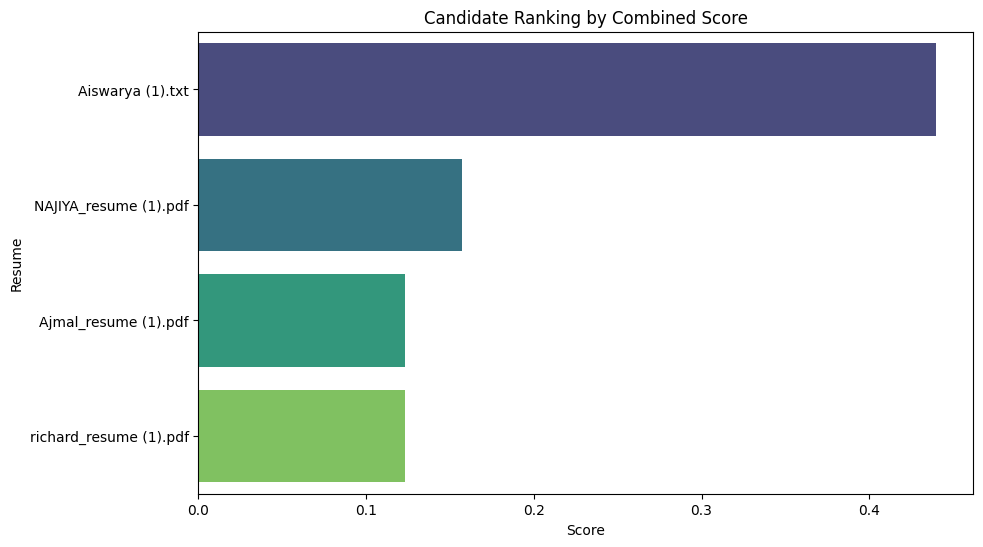

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x="Combined Score", y="Resume", data=df_results, palette="viridis")
plt.title("Candidate Ranking by Combined Score")
plt.xlabel("Score")
plt.ylabel("Resume")
plt.show()


EXPORT RESULTS:

In [26]:
df_results.to_csv("resume_screening_results.csv", index=False)
print("Results exported to resume_screening_results.csv")


Results exported to resume_screening_results.csv


In [38]:
from google.colab import files
files.download("resume_screening_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
!pip install plotly ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.5 MB/s eta 0:00:00


In [36]:
!pip install plotly ipywidgets --quiet

# Enable ipywidgets in Colab
from google.colab import output
output.enable_custom_widget_manager()


In [37]:
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output

# Ensure df_results is sorted and cleaned
df = df_results.copy()

# Dropdown for selecting plot type
plot_selector = widgets.Dropdown(
    options=['Bar Plot', 'Pie Chart', 'Line Plot', 'Histogram'],
    value='Bar Plot',
    description='Plot Type:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Output area for the plot
plot_output = widgets.Output()

# Define the plotting function
def update_plot(change):
    with plot_output:
        clear_output(wait=True)
        plot_type = change['new']

        if plot_type == 'Bar Plot':
            fig = px.bar(
                df, x='Combined Score', y='Resume', orientation='h',
                color='Combined Score', color_continuous_scale='Viridis',
                title="Candidate Ranking by Combined Score"
            )
            fig.update_layout(yaxis={'categoryorder':'total ascending'})

        elif plot_type == 'Pie Chart':
            fig = px.pie(
                df, names='Resume', values='Combined Score',
                color_discrete_sequence=px.colors.qualitative.Set3,
                title="Candidate Score Distribution"
            )

        elif plot_type == 'Line Plot':
            fig = px.line(
                df.sort_values('Combined Score'), x='Resume', y='Combined Score',
                markers=True, title="Line Plot of Candidate Scores"
            )
            fig.update_traces(line=dict(width=4))

        elif plot_type == 'Histogram':
            fig = px.histogram(
                df, x='Combined Score', nbins=10,
                color_discrete_sequence=['royalblue'],
                title="Histogram of Combined Scores"
            )

        # Smooth transitions (light animation effect)
        fig.update_layout(transition_duration=1000)
        fig.show()

# Attach handler
plot_selector.observe(update_plot, names='value')

# Display dropdown and initial plot
display(plot_selector, plot_output)
update_plot({'new': plot_selector.value})  # Trigger the first plot


Dropdown(description='Plot Type:', layout=Layout(width='50%'), options=('Bar Plot', 'Pie Chart', 'Line Plot', …

Output()